In [9]:
import numpy as np
import matplotlib as mtlp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import yaml
import pymc3 as pm
import math
import arviz as az
import theano
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import corner as crn
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
######
import sys
sys.path.append('../HelpherFunctions/')
from Chi2Allvar import *
######
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'serf'
filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)

In [10]:

def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res
unity = lambda x : x

In [14]:
def runMCMC(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        k2 = pm.Uniform('k2', lower=limits[2], upper=limits[3])
        k3 = pm.Uniform('k3', lower=limits[4], upper=limits[5])

        like = pm.Potential('like', likelihood(k1, k2, k3))
        
    if fit:
        with model:
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) # Turn on to print summary
            if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
        return trace, model
    return model

def makeCorner(trace, model, filename, collider, label, limit, lambdas=[unity, unity, unity]):
    """ Corner plot builder
    argument:
        trace: the trace from the pyMC3 run
        filename: the file to save the plot in
        collider: a string with the collider name to attach to the plot
    """
    var = ['k1', 'k2', 'k3']
    
    samples = np.vstack((lambdas[0](trace['k1']), lambdas[1](trace['k2']), lambdas[2](trace['k3']))).T

    if lambdas[0] != unity:
        limit_t = np.array(limit)
        limit_t[0] = lambdas[0](limit[1])
        limit_t[1] = lambdas[0](limit[0])
        limit_t[2] = lambdas[1](limit[3])
        limit_t[3] = lambdas[1](limit[2])
        limit_t[4] = lambdas[2](limit[5])
        limit_t[5] = lambdas[2](limit[4])
        limits = limit_t
    else: limits = limit
    
    
    fig = plt.figure(figsize=(12,12))
    fig = crn.corner(samples,labels = [label[0], label[1], label[2]], 
                     truths = None, bins=NBINS,
                     show_titles=True, title_kwargs={"fontsize": 30}, label_kwargs={"fontsize": 30},
                     levels=(1.-np.exp(-0.5),1.-np.exp(-2.),
                             #1.-np.exp(-4.5)
                            ), 
                     plot_contours = True, fill_contours=True, smooth=True, smooth1d=None,
                     plot_datapoints = False, color='#937eba', labelpad=-0.15, fig=fig, title_fmt='.3f', hist_kwargs={'linewidth': 2, 'histtype': 'bar'}, 
                     range=[(limits[0],limits[1]), (limits[2], limits[3]), (limits[4], limits[5])], truth_color='#343434')
    
    stats_func_1 = {
        'b0': lambda x: multimode(x, 0, 0.6827),
        'b1': lambda x: multimode(x, 1, 0.6827),
        }
    
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    
 #   stats_func_3 = {
  ##      'b0': lambda x: multimode(x, 0, 0.9973),
  #      'b1': lambda x: multimode(x, 1, 0.9973),
  #      }
    
    df_1 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.6827, round_to='none', stat_funcs=stats_func_1))
    df_2 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
  #  df_3 = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.9973, round_to='none', stat_funcs=stats_func_3))

    for ax in fig.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=28, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=28, rotation=0,right=True,size=10 )
    
    ax = fig.get_axes()
    
    for j in range(3):
        for i in range(NBINS):
            
            lim_1l = min(lambdas[j](df_1.loc[var[j]]['b0']), lambdas[j](df_1.loc[var[j]]['b1']))
            lim_1u = max(lambdas[j](df_1.loc[var[j]]['b0']), lambdas[j](df_1.loc[var[j]]['b1']))
            
            lim_2l = min(lambdas[j](df_2.loc[var[j]]['b0']), lambdas[j](df_2.loc[var[j]]['b1']))
            lim_2u = max(lambdas[j](df_2.loc[var[j]]['b0']), lambdas[j](df_2.loc[var[j]]['b1']))
            
      #      lim_3l = min(lambdas[j](df_3.loc[var[j]]['b0']), lambdas[j](df_3.loc[var[j]]['b1']))
       #     lim_3u = max(lambdas[j](df_3.loc[var[j]]['b0']), lambdas[j](df_3.loc[var[j]]['b1']))
            
            if ax[4*j].patches[i].xy[0] > lim_1l and ax[4*j].patches[i].xy[0] < lim_1u:
                ax[4*j].patches[i].set_alpha(1)
            elif ax[4*j].patches[i].xy[0] > lim_2l and ax[4*j].patches[i].xy[0] < lim_2u:
                ax[4*j].patches[i].set_alpha(0.5)
           # elif ax[4*j].patches[i].xy[0] > lim_3l and ax[4*j].patches[i].xy[0] < lim_3u:
             #   ax[4*j].patches[i].set_alpha(0.25)
            else:
                ax[4*j].patches[i].set_alpha(0.25)
    
    
    ## 1D histogram labels
    ax[0].set_title(label[0]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[0](df_2.loc['k1']['hdi_2.275%']), lambdas[0](df_2.loc['k1']['hdi_97.725%'])), fontsize=30)
    ax[4].set_title(label[1]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[0](df_2.loc['k2']['hdi_2.275%']), lambdas[0](df_2.loc['k2']['hdi_97.725%'])), fontsize=30)
    ax[8].set_title(label[2]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[0](df_2.loc['k3']['hdi_2.275%']), lambdas[0](df_2.loc['k3']['hdi_97.725%'])), fontsize=30)
    #if collider == 'HL-LHC': ax[8].set_title(label[2]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[2](df_1.loc['k3']['hdi_84.135%']), lambdas[2](df_1.loc['k3']['hdi_15.865%'])), fontsize=22)
    #else: ax[8].set_title(label[2]+r'$ = [{:.3f}, {:.3f}]$'.format(lambdas[2](df_1.loc['k3']['hdi_84.135%']), lambdas[2](df_1.loc['k3']['hdi_15.865%'])), fontsize=22)
    
    ## title
    ax[1].annotate(collider, xy=(0.5, 0.7), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=28, fontweight='bold')
    ax[1].annotate(r'Higgs data @ 95\% CI ', xy=(0.5, 0.5), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=26)
    ax[1].annotate(r'$\mu^L\,\lambda_3^L$', xy=(0.5, 0.3), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=26)
   # ax[1].annotate(label[1]+r'$ = 0$', xy=(0.5, 0.4), xycoords='axes fraction', horizontalalignment='center',
             #   verticalalignment='center', fontsize=22)
   # ax[1].annotate(label[2]+r'$ = 0$', xy=(0.5, 0.3), xycoords='axes fraction', horizontalalignment='center',
           #     verticalalignment='center', fontsize=22)
    
    ## grid
    #ax[3].grid(linestyle=':', zorder=0)
   # ax[6].grid(linestyle=':', zorder=0)
   # ax[7].grid(linestyle=':', zorder=0)
    ax[3].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[3].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    ax[6].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[6].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    ax[7].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[7].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
## 
llCqtm =lambda Cqu1,Cqu8,CH :mylikelihoodAV(Cqu1,Cqu8,0.0,0.0,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=True,linearmu=True)
limits = [-2.5, 1.5,-15.5,10.5, -15, 140]
config = [15000, 0.8, 50]
trace_1, model_1 = runMCMC(llCqtm, limits, config=config)
filename = '../results/plots/Cqt1_Cqt8_Cphi.pdf'
makeCorner(trace_1, model_1, filename, collider=r'ATLAS+CMS', 
           label=[r"$C_{Qt}^{(1)}$",r"$C_{Qt}^{(8)}$", r"$C_\phi$"], 
           limit=limits)

In [ ]:
llCqtm =lambda Cqu1,Cqu8,CH :mylikelihoodAV(0.0,0.0,Cqu1,Cqu8,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=True,linearmu=True)
limits = [-8.5, 12.5,-60.5,50, -60, 160]
config = [150000, 0.8, 50]
trace_1, model_1 = runMCMC(llCqtm, limits, config=config)
filename = '../results/plots/Cqtqb1_Cqtqb8_Cphi.pdf'
makeCorner(trace_1, model_1, filename, collider='ATLAS+CMS', 
           label=[r"$C_{QtQb}^{(1)}$",r"$C_{QtQb}^{(8)}$", r"$C_\phi$"], 
           limit=limits)

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 18500
Interrupted at 18,499 [9%]: Average Loss = 183.97
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k3, k2, k1]


Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 2300
Interrupted at 2,299 [1%]: Average Loss = 16.185
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k3, k2, k1]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 3454 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


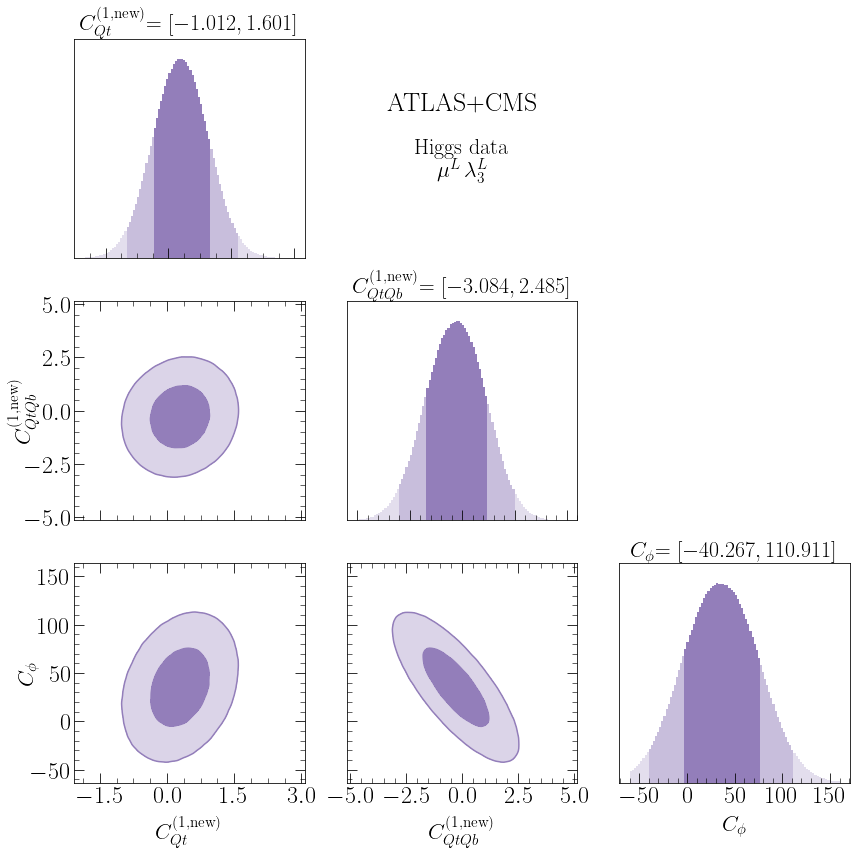

In [46]:
CF= 4/3
Nc=3
llCqtm =lambda Cqu,Cquqb,CH :mylikelihoodAV(Cqu/2,1/2/CF*Cqu,1/(2*Nc+1)*Cquqb/2,1/CF*Cquqb/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=True,linearmu=True)
limits = [-2.0, 3.0,-5.,5., -60, 160]
config = [150000, 0.8, 50]
trace_1, model_1 = runMCMC(llCqtm, limits, config=config)
filename = '../results/plots/Cqtnew_Cqtqbnew_Cphi.pdf'
makeCorner(trace_1, model_1, filename, collider='ATLAS+CMS', 
           label=[r"$C_{Qt}^{(1,\mathrm{new})}$",r"$C_{QtQb}^{(1,\mathrm{new})}$", r"$C_\phi$"], 
           limit=limits)